In [124]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
sys.path.append('./../')
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('./../data/raw/btcusdt.csv')
from models.grid_bot import GridBot

In [164]:
class GridBot:
    def __init__(
            self,
            levels_num=10,
            balance=100000,
            levels_step=0.001, # must be > 0.0044
            fee=0.2181 / 100,
            use_up=False
    ):

        assert 0 < levels_step < 1, f'levels_step must be in (0, 1) range, {levels_step}'
        assert levels_num >= 1, f'levels_num must be greater than 0, {levels_num}'

        self.levels_num = levels_num
        self.levels_step = levels_step
        self.balance = balance
        self.history = []
        self.ref_price = None
        self.buy_orders = []
        self.sell_orders = []
        self.fee = fee
        self.buy_points = []
        self.sell_points = []
        self.use_up = use_up
        self.assets = 0
        self.wasted = []
        self.bought = [False for _ in range(self.levels_num)]

    def trade(self, df):
#         df = pd.read_csv(df_path)
        ref_price = df.iloc[0]['Open']

        self.ref_price = ref_price
        buy_amount = self.balance / self.levels_num
        buy_orders = [ref_price * (1 - k * self.levels_step) for k in range(1, self.levels_num + 1)]

        if self.use_up:
            sell_orders = [ref_price * (1 + k * self.levels_step) for k in range(self.levels_num)]
        else:
            sell_orders = [ref_price * (1 - k * self.levels_step) for k in range(self.levels_num)]

        self.buy_orders = buy_orders
        self.sell_orders = sell_orders

        for index, row in tqdm(df.iterrows()):

            sell_amount = self.assets / sum(self.bought) if sum(self.bought) else 0

            for i in range(len(self.bought)):
                if self.bought[i] and row.High >= sell_orders[i]:
                    self.bought[i] = False
                    
                    self.balance += (
                        sell_amount * sell_orders[i] * (1 - self.fee)
                    )
                    self.wasted += [sell_amount * sell_orders[i] * self.fee]
                    self.assets -= sell_amount

                    self.history += [self.balance]
                    self.sell_points += [(index, sell_orders[i])]

                elif not self.bought[i] and row.Low <= buy_orders[i] and self.balance >= buy_amount:
                    self.bought[i] = True
                    self.balance -= buy_amount
                    self.assets += (1 - self.fee) * buy_amount / buy_orders[i]
                    self.wasted += [self.fee * buy_amount / buy_orders[i]]
                    self.history += [self.balance]
                    self.buy_points += [(index, buy_orders[i])]

        return self
    
    def plot(self, df_path):
        df = pd.read_csv(df_path)
        self = self.trade(df_path)
        plt.figure(figsize=(24,8))
        plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
             linewidth=1, markersize=1)

        plt.plot(df.index, [self.ref_price for i in df.index], color='blue', linewidth=3, label='ref')
        plt.plot(df.index, [self.buy_orders for i in df.index], color='green', linewidth=0.5, linestyle='--' )
        plt.plot(df.index, [self.sell_orders for i in df.index] , color='red', linewidth=0.5, linestyle='--')

        plt.plot([i[0] for i in self.sell_points], [i[1] for i in self.sell_points] , 'ro', linewidth=2)
        plt.plot([i[0] for i in self.buy_points], [i[1] for i in self.buy_points] , 'go', linewidth=2)

        plt.legend()
        plt.show()

In [148]:
grid_bot = GridBot(levels_num=14, balance=100000, use_up = True, levels_step=0.0012)
grid_bot.trade('./../data/raw/btcusdt.csv')
print(grid_bot.balance)

4321it [00:00, 13054.47it/s]

101220.79050678137


In [151]:
sum(grid_bot.wasted)

798.9401159282847

In [152]:
len(grid_bot.buy_points), len(grid_bot.sell_points)

(51, 51)

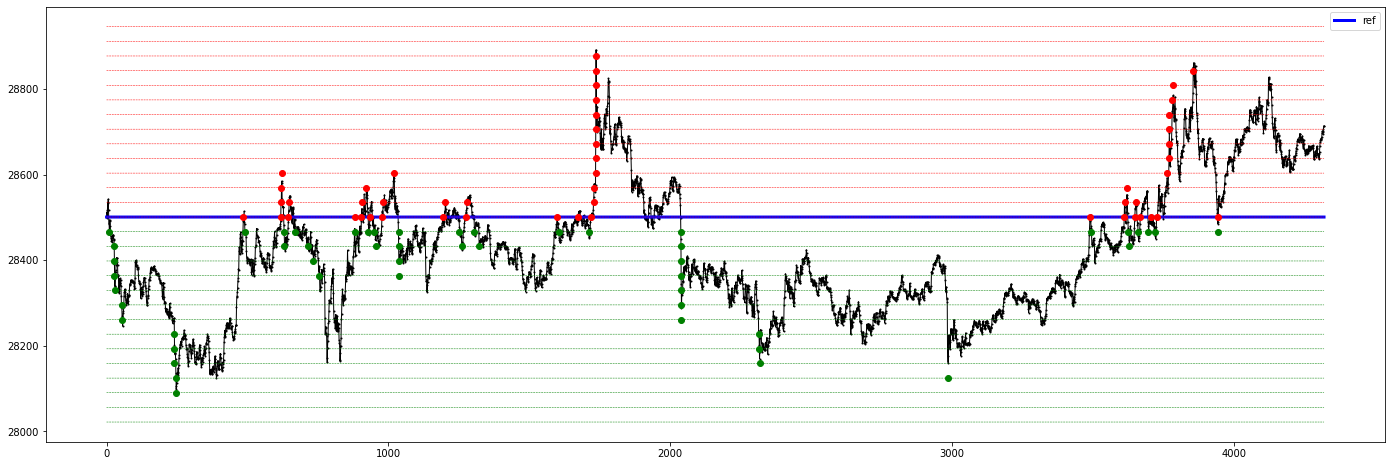

In [153]:
plt.figure(figsize=(24,8))
plt.plot(df.index, (df.High+df.Low)/2, color='black', marker='o', linestyle='-',
     linewidth=1, markersize=1)

plt.plot(df.index, [grid_bot.ref_price for i in df.index ], color='blue', linewidth=3, label='ref')
plt.plot(df.index, [grid_bot.buy_orders for i in df.index ], color ='green', linewidth =0.5, linestyle='--' )
plt.plot(df.index, [grid_bot.sell_orders for i in df.index ] , color ='red', linewidth =0.5, linestyle='--')

plt.plot([i[0] for i in grid_bot.sell_points], [i[1] for i in grid_bot.sell_points] , 'ro', linewidth =2)
plt.plot([i[0] for i in grid_bot.buy_points], [i[1] for i in grid_bot.buy_points] , 'go', linewidth =2)

plt.legend()
plt.show()

4321it [00:00, 16320.37it/s]


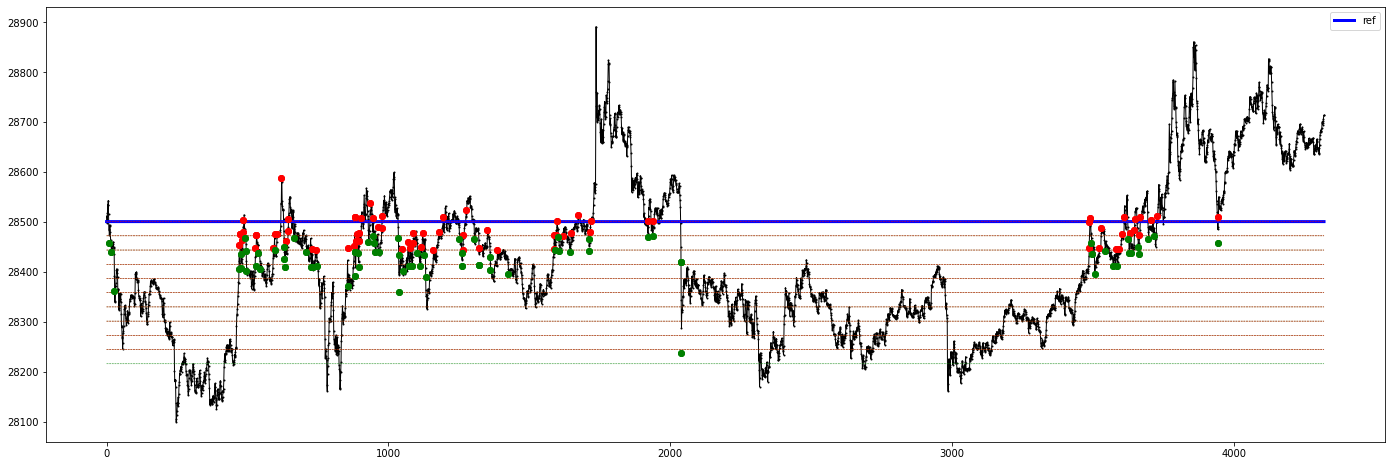

In [5]:
grid_bot.plot('./../data/raw/btcusdt.csv')

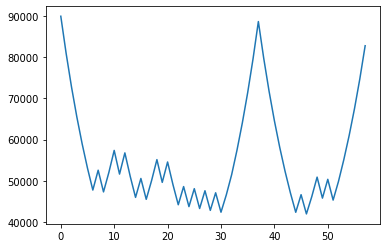

In [123]:
plt.plot(grid_bot.history)

In [160]:
df

,Time,Open,High,Low,Close,Volume
0,2023-10-17 00:00:00,28500.77,28522.68,28500.77,28515.91,50.70982
1,2023-10-17 00:01:00,28515.91,28515.92,28496.23,28496.23,23.65223
2,2023-10-17 00:02:00,28496.24,28507.30,28488.15,28507.29,26.60150
3,2023-10-17 00:03:00,28507.29,28528.52,28507.29,28528.52,25.37479
4,2023-10-17 00:04:00,28528.52,28541.50,28528.51,28540.52,39.02155
...,...,...,...,...,...,...
4316,2023-10-19 23:56:00,28694.02,28703.57,28694.02,28700.84,9.59389
4317,2023-10-19 23:57:00,28700.83,28704.71,28700.83,28704.71,8.85771
4318,2023-10-19 23:58:00,28704.70,28711.63,28703.08,28709.84,36.94430
4319,2023-10-19 23:59:00,28709.83,28717.82,28709.83,28713.71,43.00736


In [161]:
day_1 = df[(df['Time'] > '2023-10-16') & (df['Time'] < '2023-10-18')]
day_2 = df[(df['Time'] > '2023-10-17') & (df['Time'] < '2023-10-19')]
day_3 = df[(df['Time'] > '2023-10-18') & (df['Time'] < '2023-10-20')]

In [ ]:
df

In [184]:
shrp = []
np.random.seed(42)
for k in range(20):
    l_n, l_s = np.random.randint(10, 14), np.random.randint(1, 10)/1000 #0.0012
    for d in [df]: #[day_1, day_2, day_3]:
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(d)
        shrp.append(grid_bot.balance - 1e5)

4321it [00:00, 13985.77it/s]
4321it [00:00, 16183.73it/s]
4321it [00:00, 16243.95it/s]
4321it [00:00, 14026.33it/s]
4321it [00:00, 14598.13it/s]
4321it [00:00, 16245.31it/s]
4321it [00:00, 13983.58it/s]
4321it [00:00, 13743.54it/s]
4321it [00:00, 16119.77it/s]
4321it [00:00, 13506.15it/s]
4321it [00:00, 14951.14it/s]
4321it [00:00, 16305.24it/s]
4321it [00:00, 16063.39it/s]
4321it [00:00, 15487.10it/s]
4321it [00:00, 13134.00it/s]
4321it [00:00, 13938.68it/s]
4321it [00:00, 14597.95it/s]
4321it [00:00, 14598.64it/s]
4321it [00:00, 16183.35it/s]
4321it [00:00, 14499.67it/s]


In [185]:
shrp

[369.4832925298251,
 110.16401494960883,
 461.20836926928314,
 689.0793216803577,
 91.80334579134069,
 443.37995103570574,
 84.74154996125435,
 298.1241118284961,
 1082.2364933375793,
 275.19148784168647,
 419.28033569933905,
 357.74893419412547,
 140.54763151363295,
 826.8951860162633,
 320.13949347747257,
 108.11356270279794,
 384.3403077244293,
 346.81778460062924,
 140.54763151363295,
 901.8637444479828]

In [186]:
np.mean(shrp)/ np.std(shrp)

1.4220228624630171

In [187]:
shrp = []
np.random.seed(42)
for k in range(20):
    l_n, l_s = np.random.randint(10, 14), np.random.randint(1, 10)/1000 #0.0012
    for d in [df]: #[day_1, day_2, day_3]:
        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(d)
        shrp.append(grid_bot.balance - 1e5)

4321it [00:00, 14647.11it/s]
4321it [00:00, 16305.68it/s]
4321it [00:00, 16430.36it/s]
4321it [00:00, 14849.51it/s]
4321it [00:00, 14074.32it/s]
4321it [00:00, 14260.74it/s]
4321it [00:00, 13461.50it/s]
4321it [00:00, 14167.08it/s]
4321it [00:00, 15945.02it/s]
4321it [00:00, 13983.49it/s]
4321it [00:00, 15376.81it/s]
4321it [00:00, 15003.03it/s]
4321it [00:00, 15885.61it/s]
4321it [00:00, 16183.57it/s]
4321it [00:00, 13893.91it/s]
4321it [00:00, 13921.91it/s]
4321it [00:00, 14747.07it/s]
4321it [00:00, 14548.71it/s]
4321it [00:00, 15106.58it/s]
4321it [00:00, 12822.61it/s]


In [189]:
np.mean(shrp)/ np.std(shrp)

-0.2599263412187479

In [195]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import time

# Initialize Binance exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1m'

# Calculate the start and end time for the one-week period
end_time = exchange.milliseconds()  # current time in milliseconds
start_time = end_time - 7 * 24 * 60 * 60 * 1000  # 7 days in milliseconds

# Initialize an empty DataFrame to store the data
all_data = pd.DataFrame()

# Define the limit for each request
limit = 1000

# Fetch OHLCV data in chunks until all data is retrieved
while True:
    # Fetch OHLCV data
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_time, limit=limit)

    # Break the loop if no more data is available
    if not ohlcv:
        break

    # Convert the data to a DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

    # Convert timestamps to human-readable format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Append the current chunk of data to the overall DataFrame
    all_data = pd.concat([all_data, df]) #.append(df, ignore_index=True)

    # Update the start_time for the next request
    start_time = ohlcv[-1][0] + 1  # set the start_time to the timestamp of the last retrieved candle + 1
    
    print(all_data.shape)
    # Pause for 3 seconds before making the next request
    time.sleep(3)

# Print the complete DataFrame
print(all_data)

              timestamp      open      high       low     close    volume
0   2023-10-15 22:11:00  27279.81  27286.24  27275.00  27286.24  28.35920
1   2023-10-15 22:12:00  27286.24  27293.33  27255.55  27255.55  41.23253
2   2023-10-15 22:13:00  27255.56  27255.56  27233.15  27249.95  49.14163
3   2023-10-15 22:14:00  27249.94  27269.99  27249.94  27261.56  18.02984
4   2023-10-15 22:15:00  27261.56  27263.88  27250.00  27251.01  12.83495
..                  ...       ...       ...       ...       ...       ...
995 2023-10-16 14:46:00  28220.41  28235.73  28150.06  28161.27  80.26163
996 2023-10-16 14:47:00  28161.27  28175.00  28136.12  28172.62  69.01721
997 2023-10-16 14:48:00  28172.62  28236.34  28172.61  28236.34  45.68398
998 2023-10-16 14:49:00  28236.33  28236.34  28189.06  28200.00  30.57133
999 2023-10-16 14:50:00  28200.00  28200.00  28173.30  28181.14  27.88970

[1000 rows x 6 columns]
(1000, 6)
              timestamp      open      high       low     close    volume
0  

              timestamp      open      high       low     close    volume
0   2023-10-22 04:11:00  29912.42  29912.42  29900.00  29900.01  12.91250
1   2023-10-22 04:12:00  29900.00  29906.76  29900.00  29906.76   7.99348
2   2023-10-22 04:13:00  29906.75  29909.75  29906.75  29909.75   4.64931
3   2023-10-22 04:14:00  29909.74  29909.75  29902.76  29902.77   8.39973
4   2023-10-22 04:15:00  29902.77  29902.77  29897.80  29897.80  11.99632
..                  ...       ...       ...       ...       ...       ...
995 2023-10-22 20:46:00  29865.83  29865.84  29864.44  29864.44   3.82760
996 2023-10-22 20:47:00  29864.45  29868.81  29864.44  29868.81  12.90392
997 2023-10-22 20:48:00  29868.80  29868.81  29858.48  29858.48  10.28651
998 2023-10-22 20:49:00  29858.49  29858.49  29856.39  29856.40   1.42894
999 2023-10-22 20:50:00  29856.40  29859.08  29856.39  29859.07   1.29903

[1000 rows x 6 columns]
(10000, 6)
             timestamp      open      high       low     close    volume
0  

In [197]:
all_data.to_csv('./btcusdt_15_20.csv')

In [198]:
all_data

,timestamp,open,high,low,close,volume
0,2023-10-15 22:11:00,27279.81,27286.24,27275.00,27286.24,28.35920
1,2023-10-15 22:12:00,27286.24,27293.33,27255.55,27255.55,41.23253
2,2023-10-15 22:13:00,27255.56,27255.56,27233.15,27249.95,49.14163
3,2023-10-15 22:14:00,27249.94,27269.99,27249.94,27261.56,18.02984
4,2023-10-15 22:15:00,27261.56,27263.88,27250.00,27251.01,12.83495
...,...,...,...,...,...,...
76,2023-10-22 22:07:00,29787.43,29793.37,29785.00,29785.00,6.22900
77,2023-10-22 22:08:00,29785.01,29785.01,29785.00,29785.01,2.05665
78,2023-10-22 22:09:00,29785.01,29785.01,29780.50,29785.00,6.80536
79,2023-10-22 22:10:00,29785.01,29793.92,29785.00,29793.91,5.04987


In [199]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import time

# Initialize Binance exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1m'

# Calculate the start and end time for the one-week period
end_time = exchange.milliseconds()  # current time in milliseconds
start_time = end_time - 21 * 24 * 60 * 60 * 1000  # 7 days in milliseconds

# Initialize an empty DataFrame to store the data
all_data = pd.DataFrame()

# Define the limit for each request
limit = 1000

# Fetch OHLCV data in chunks until all data is retrieved
while True:
    # Fetch OHLCV data
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=start_time, limit=limit)

    # Break the loop if no more data is available
    if not ohlcv:
        break

    # Convert the data to a DataFrame
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

    # Convert timestamps to human-readable format
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

    # Append the current chunk of data to the overall DataFrame
    all_data = pd.concat([all_data, df]) #.append(df, ignore_index=True)

    # Update the start_time for the next request
    start_time = ohlcv[-1][0] + 1  # set the start_time to the timestamp of the last retrieved candle + 1
    
    print(all_data.shape)
    # Pause for 3 seconds before making the next request
    time.sleep(3)

# Print the complete DataFrame
print(all_data)

(1000, 6)
(2000, 6)
(3000, 6)
(4000, 6)
(5000, 6)
(6000, 6)
(7000, 6)
(8000, 6)
(9000, 6)
(10000, 6)
(11000, 6)
(12000, 6)
(13000, 6)
(14000, 6)
(15000, 6)
(16000, 6)
(17000, 6)
(18000, 6)
(19000, 6)
(20000, 6)
(21000, 6)
(22000, 6)
(23000, 6)
(24000, 6)
(25000, 6)
(26000, 6)
(27000, 6)
(28000, 6)
(29000, 6)
(30000, 6)
(30241, 6)
              timestamp      open      high       low     close      volume
0   2023-10-01 22:17:00  27392.04  28000.00  27392.03  27994.54  1165.76179
1   2023-10-01 22:18:00  27994.54  28000.00  27750.00  27872.69   731.89361
2   2023-10-01 22:19:00  27874.98  27914.89  27831.00  27861.39   344.48555
3   2023-10-01 22:20:00  27861.40  27876.80  27735.30  27750.57   225.79096
4   2023-10-01 22:21:00  27750.57  27825.00  27750.56  27799.18   150.65462
..                  ...       ...       ...       ...       ...         ...
236 2023-10-22 22:13:00  29798.96  29798.97  29798.96  29798.96     1.44329
237 2023-10-22 22:14:00  29798.96  29808.08  29798.96  29808

In [219]:
all_data.to_csv('./btcusdt_01_22.csv')

In [218]:
all_data

,timestamp,Open,High,Low,Close,Volume
0,2023-10-01 22:17:00,27392.04,28000.00,27392.03,27994.54,1165.76179
1,2023-10-01 22:18:00,27994.54,28000.00,27750.00,27872.69,731.89361
2,2023-10-01 22:19:00,27874.98,27914.89,27831.00,27861.39,344.48555
3,2023-10-01 22:20:00,27861.40,27876.80,27735.30,27750.57,225.79096
4,2023-10-01 22:21:00,27750.57,27825.00,27750.56,27799.18,150.65462
...,...,...,...,...,...,...
236,2023-10-22 22:13:00,29798.96,29798.97,29798.96,29798.96,1.44329
237,2023-10-22 22:14:00,29798.96,29808.08,29798.96,29808.08,9.78940
238,2023-10-22 22:15:00,29808.07,29814.89,29808.07,29814.89,4.77855
239,2023-10-22 22:16:00,29814.88,29814.89,29814.88,29814.89,6.43159


In [217]:
all_data.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace= True)

## 1 day sharp

In [285]:
shrp = []
np.random.seed(42)

for j in range(1):
    l_n, l_s = 8, 0.0012 #np.random.randint(10, 16)/1000 #0.0012
    for k in range(2, 23):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

1439it [00:00, 17227.99it/s]
1439it [00:00, 16920.72it/s]
1439it [00:00, 17547.55it/s]
1439it [00:00, 17378.29it/s]
1439it [00:00, 17134.97it/s]
1439it [00:00, 17337.86it/s]
1439it [00:00, 17127.67it/s]
1439it [00:00, 17331.09it/s]
1439it [00:00, 16927.98it/s]
1439it [00:00, 16728.34it/s]
1439it [00:00, 16809.74it/s]
1439it [00:00, 16355.81it/s]
1439it [00:00, 16928.74it/s]
1439it [00:00, 16927.93it/s]
1439it [00:00, 17547.25it/s]
1439it [00:00, 17129.71it/s]
1439it [00:00, 16928.45it/s]
1439it [00:00, 14534.31it/s]
1439it [00:00, 16730.85it/s]
1439it [00:00, 16734.19it/s]
1337it [00:00, 17361.24it/s]


In [286]:
shrp, np.mean(shrp)/ np.std(shrp)

([-89377.73300080406,
  -27437.061078464147,
  -1026.0321326636622,
  -88637.39348683471,
  -393.9435784549132,
  -434.5660747415095,
  -13705.99749437967,
  -88039.74033289163,
  -77042.87804266709,
  -88134.5058940587,
  -39402.2035989666,
  -157.99786533380393,
  -118.51188870164333,
  -79.02591206948273,
  0.0,
  -40728.324739635005,
  -26977.519524906238,
  -473.5557505011675,
  -157.85358488785278,
  -276.1867147167359,
  -38677.46737445384],
 -0.8524075374088774)

In [291]:
shrp = []
np.random.seed(42)

for j in range(1):
    l_n, l_s = 14, 0.0012 #np.random.randint(10, 16)/1000 #0.0012
    for k in range(2, 23):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

1439it [00:00, 12735.87it/s]
1439it [00:00, 12967.69it/s]
1439it [00:00, 13081.97it/s]
1439it [00:00, 12960.31it/s]
1439it [00:00, 13202.01it/s]
1439it [00:00, 12734.60it/s]
1439it [00:00, 12622.59it/s]
1439it [00:00, 12626.18it/s]
1439it [00:00, 12963.79it/s]
1439it [00:00, 13082.11it/s]
1439it [00:00, 12736.27it/s]
1439it [00:00, 12733.66it/s]
1439it [00:00, 12957.72it/s]
1439it [00:00, 12734.42it/s]
1439it [00:00, 13081.94it/s]
1439it [00:00, 12739.84it/s]
1439it [00:00, 11242.46it/s]
1439it [00:00, 12734.82it/s]
1439it [00:00, 12964.12it/s]
1439it [00:00, 12299.11it/s]
1337it [00:00, 12729.98it/s]


In [292]:
shrp, np.mean(shrp)/ np.std(shrp)

([-93001.13877691804,
  -71551.6091383583,
  -47.155818793253275,
  -85660.05646441913,
  179.94495174169424,
  -7324.674641316975,
  -57119.98092036046,
  -92873.50019379625,
  -57162.96597623487,
  -92857.14285714288,
  -64335.89042839491,
  -56.08660284912912,
  -7183.7323620426905,
  -45.1576640396961,
  0.0,
  -92618.11951917727,
  -50151.21156327543,
  35.98560957987502,
  12.515258127095876,
  58.61080360785127,
  -50055.36279910805],
 -1.0255927370121742)

In [256]:
shrp = []
np.random.seed(42)

for j in range(1):
    l_n, l_s = 11, 0.0009 #np.random.randint(10, 16)/1000 #0.0012
    for k in range(2, 23):
        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

1439it [00:00, 14825.59it/s]
1439it [00:00, 15147.59it/s]
1439it [00:00, 14983.52it/s]
1439it [00:00, 14988.44it/s]
1439it [00:00, 12931.99it/s]
1439it [00:00, 14536.51it/s]
1439it [00:00, 14831.46it/s]
1439it [00:00, 13958.99it/s]
1439it [00:00, 14683.70it/s]
1439it [00:00, 15146.49it/s]
1439it [00:00, 14683.77it/s]
1439it [00:00, 14834.12it/s]
1439it [00:00, 14835.29it/s]
1439it [00:00, 14834.27it/s]
1439it [00:00, 13201.81it/s]
1439it [00:00, 14675.38it/s]
1439it [00:00, 14836.02it/s]
1439it [00:00, 14671.89it/s]
1439it [00:00, 15000.43it/s]
1439it [00:00, 14835.32it/s]
1337it [00:00, 14701.35it/s]


In [257]:
shrp, np.mean(shrp)/ np.std(shrp)

([-91125.81076946604,
  -91121.29687221246,
  -104.33447234498453,
  -99834.19550461661,
  243.73437302414095,
  -9426.369083856698,
  -90895.17326389655,
  -90942.16945959689,
  -90988.03553037092,
  -99999.99999999997,
  -91033.07334390863,
  -124.63819843466626,
  -9149.740578452955,
  -62.91559201461496,
  0.0,
  -91055.21666756636,
  -82167.67680472769,
  13.83396651649673,
  6.223090218831203,
  91.99594070477178,
  -91110.04730711308],
 -1.085304074648248)

In [225]:
shrp = []
np.random.seed(42)

for j in range(20):
    l_n, l_s = np.random.randint(10, 14), np.random.randint(10, 20)/1000 #0.0012
    for k in range(2, 23):

        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+1}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

1439it [00:00, 13836.62it/s]
1439it [00:00, 14247.75it/s]
1439it [00:00, 12405.38it/s]
1439it [00:00, 14107.81it/s]
1439it [00:00, 13970.98it/s]
1439it [00:00, 14246.54it/s]
1439it [00:00, 13971.24it/s]
1439it [00:00, 13324.13it/s]
1439it [00:00, 13704.51it/s]
1439it [00:00, 13704.92it/s]
1439it [00:00, 13704.01it/s]
1439it [00:00, 13201.98it/s]
1439it [00:00, 13574.29it/s]
1439it [00:00, 14107.84it/s]
1439it [00:00, 13575.51it/s]
1439it [00:00, 13448.55it/s]
1439it [00:00, 13704.17it/s]
1439it [00:00, 13704.98it/s]
1439it [00:00, 13574.53it/s]
1439it [00:00, 13836.94it/s]
1337it [00:00, 12496.48it/s]
1439it [00:00, 15148.35it/s]
1439it [00:00, 15475.35it/s]
1439it [00:00, 15307.29it/s]
1439it [00:00, 15145.69it/s]
1439it [00:00, 14988.51it/s]
1439it [00:00, 14988.36it/s]
1439it [00:00, 15474.04it/s]
1439it [00:00, 15309.46it/s]
1439it [00:00, 15813.55it/s]
1439it [00:00, 15639.03it/s]
1439it [00:00, 14834.81it/s]
1439it [00:00, 14989.93it/s]
1439it [00:00, 14990.00it/s]
1439it [00:00,

1439it [00:00, 15474.48it/s]
1439it [00:00, 15641.34it/s]
1439it [00:00, 15307.68it/s]
1439it [00:00, 15469.76it/s]
1439it [00:00, 13073.16it/s]
1439it [00:00, 15473.25it/s]
1439it [00:00, 15473.21it/s]
1439it [00:00, 15308.80it/s]
1439it [00:00, 15306.79it/s]
1439it [00:00, 15147.36it/s]
1439it [00:00, 15475.27it/s]
1337it [00:00, 15183.83it/s]
1439it [00:00, 13201.95it/s]
1439it [00:00, 13191.02it/s]
1439it [00:00, 13201.98it/s]
1439it [00:00, 13200.05it/s]
1439it [00:00, 13323.28it/s]
1439it [00:00, 13326.01it/s]
1439it [00:00, 13448.85it/s]
1439it [00:00, 9923.75it/s]
1439it [00:00, 13448.76it/s]
1439it [00:00, 12195.77it/s]
1439it [00:00, 12300.19it/s]
1439it [00:00, 13201.87it/s]
1439it [00:00, 13448.85it/s]
1439it [00:00, 13326.28it/s]
1439it [00:00, 13324.36it/s]
1439it [00:00, 13324.19it/s]
1439it [00:00, 13081.69it/s]
1439it [00:00, 13330.28it/s]
1439it [00:00, 13575.78it/s]
1439it [00:00, 12734.71it/s]
1337it [00:00, 13108.03it/s]
1439it [00:00, 13081.94it/s]
1439it [00:00, 

In [226]:
np.mean(shrp)/ np.std(shrp)

-0.6260781096743387

([-93027.42274743768,
  -93023.87611388127,
  -81.97708541394968,
  -99869.72503934173,
  191.5055788046593,
  -7406.432851601727,
  -71417.63613591877,
  -92883.13314682618,
  -78633.45648814866,
  -92857.14285714288,
  -85811.7004844997,
  -97.93001305582584,
  -7189.08188307019,
  -49.43367944005877,
  0.0,
  -99946.15801043752,
  -64560.31748942899,
  10.869545120061957,
  4.889570886225556,
  72.28252483942197,
  -71586.46574130323],
 -1.0608118745111106)

In [253]:
np.mean(shrp)/ np.std(shrp)

-1.0608118745111106

## 7 day sharp

In [297]:
shrp = []
np.random.seed(42)

for j in range(1):
    l_n, l_s = 8, 0.001 #0.0012
    for k in range(2, 23):

        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+7}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = False, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

10079it [00:00, 17437.56it/s]
10079it [00:00, 17559.05it/s]
10079it [00:00, 17288.01it/s]
10079it [00:00, 17528.49it/s]
10079it [00:00, 16996.31it/s]
10079it [00:00, 17347.49it/s]
10079it [00:00, 16714.91it/s]
10079it [00:00, 17436.79it/s]
10079it [00:00, 16910.75it/s]
10079it [00:00, 17590.17it/s]
10079it [00:00, 17199.49it/s]
10079it [00:00, 16996.89it/s]
10079it [00:00, 17621.03it/s]
10079it [00:00, 17377.35it/s]
9977it [00:00, 17689.59it/s]
8537it [00:00, 17107.93it/s]
7097it [00:00, 17480.48it/s]
5657it [00:00, 17622.80it/s]
4217it [00:00, 17551.79it/s]
2777it [00:00, 17569.98it/s]
1337it [00:00, 17141.12it/s]


In [298]:
shrp, np.mean(shrp)/ np.std(shrp)

([-33655.149663736476,
  -9104.986330622516,
  -16991.261665762548,
  -92501.08654274278,
  -90474.38629434945,
  -90617.79563026692,
  -89752.5245725385,
  -88099.38831790314,
  -2390.1293520350155,
  -1467.1659048199217,
  -4237.523070669849,
  -210.00029130256735,
  -210.01901574010844,
  -84.01509607105982,
  0.0,
  -7760.711206165652,
  -3985.835639070312,
  -671.2470621239627,
  -209.86896965958294,
  -377.5921408913564,
  -51801.90800373319],
 -0.7518907541026172)

In [301]:
shrp = []
np.random.seed(42)

for j in range(1):
    l_n, l_s = 8, 0.0012 #0.0012
    for k in range(2, 23):

        df = all_data[(all_data['timestamp'] > f'2023-10-{k}') & (all_data['timestamp'] < f'2023-10-{k+7}')]

        grid_bot = GridBot(levels_num=l_n, balance=100000, use_up = True, levels_step=l_s)
        grid_bot.trade(df)
        shrp.append(grid_bot.balance - 1e5)

10079it [00:00, 17199.46it/s]
10079it [00:00, 13209.58it/s]
10079it [00:00, 17407.64it/s]
10079it [00:00, 17141.10it/s]
10079it [00:00, 16826.30it/s]
10079it [00:00, 17437.58it/s]
10079it [00:00, 17651.57it/s]
10079it [00:00, 16659.45it/s]
10079it [00:00, 17317.04it/s]
10079it [00:00, 17870.24it/s]
10079it [00:00, 17170.01it/s]
10079it [00:00, 17744.65it/s]
10079it [00:00, 17620.51it/s]
10079it [00:00, 17590.03it/s]
9977it [00:00, 17084.40it/s]
8537it [00:00, 17246.43it/s]
7097it [00:00, 17439.82it/s]
5657it [00:00, 17122.24it/s]
4217it [00:00, 17004.92it/s]
2777it [00:00, 14849.70it/s]
1337it [00:00, 16506.35it/s]


In [302]:
shrp, np.mean(shrp)/ np.std(shrp)

([-88098.3476043481,
  -62.072492373743444,
  -25543.39414561825,
  -99586.39739866406,
  -87789.92735258861,
  -88117.6416231941,
  -99979.54806230715,
  -87528.62533914339,
  348.66138955103816,
  526.0504137207754,
  -45.122642793139676,
  -98.15155498599051,
  -167.6191421643307,
  -79.02591206948273,
  0.0,
  401.38582801943994,
  -99.79260089213494,
  62.974816764792195,
  21.901701722454163,
  102.56890631376882,
  -87596.88489843904],
 -0.7407870495128439)

## 15 day sharp